In [320]:
import re
import nltk
from nltk.corpus import stopwords

import numpy as np
import pandas as pd
from gensim.utils import simple_preprocess
from tqdm import tqdm
tqdm.pandas()

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import os
from sklearn import metrics
from matplotlib import pyplot as plt


stop_words = set(stopwords.words('english'))


In [76]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [3]:
df = pd.read_csv('./dataset/movie.csv')
df = df.loc[:5000]
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.strip()
df['text'] = df['text'].apply(lambda x: re.sub('\d+','',x))

print(df['label'].value_counts())
df.head()

label
0    2582
1    2419
Name: count, dtype: int64


,text,label
0,i grew up (b. ) watching and loving the thunde...,0
1,"when i put this movie in my dvd player, and sa...",0
2,why do people who do not know what a particula...,0
3,even though i have great interest in biblical ...,0
4,im a die hard dads army fan and nothing will e...,1


In [4]:
df['tokens_gensim'] = df['text'].progress_apply(simple_preprocess)

stop_words = set(stopwords.words('english'))
a = list(stop_words)
a.append('br')
a.append('movie')
a.append('watch')
df['tokens_gensim'] = df['tokens_gensim'].progress_apply(lambda x: [i for i in x if i not in a])


100%|██████████| 5001/5001 [00:02<00:00, 2013.85it/s]


In [5]:
df.head()

,text,label,tokens_gensim
0,i grew up (b. ) watching and loving the thunde...,0,"[grew, watching, loving, thunderbirds, mates, ..."
1,"when i put this movie in my dvd player, and sa...",0,"[put, dvd, player, sat, coke, chips, expectati..."
2,why do people who do not know what a particula...,0,"[people, know, particular, time, past, like, f..."
3,even though i have great interest in biblical ...,0,"[even, though, great, interest, biblical, movi..."
4,im a die hard dads army fan and nothing will e...,1,"[im, die, hard, dads, army, fan, nothing, ever..."


In [44]:
df.shape

(5001, 3)

In [47]:
class_0 = df.loc[df.label == 0, :]
class_1 = df.loc[df.label == 1, :]

test_0 = class_0.iloc[:500, :]
test_1 = class_1.iloc[:500, :]
valid_0 = class_0.iloc[500:1000, :]
valid_1 = class_1.iloc[500:1000, :]
train_0 = class_0.iloc[1000:, :]
train_1 = class_1.iloc[1000:, :]

train_df = pd.concat([train_0, train_1], axis=0).reset_index(drop=True)
print(train_df.shape)

val_df = pd.concat([valid_0, valid_1], axis=0).reset_index(drop=True)
print(val_df.shape)

test_df = pd.concat([test_0, test_1], axis=0).reset_index(drop=True)
print(test_df.shape)

(3001, 3)
(1000, 3)
(1000, 3)


# GloVe

In [8]:
def load_glove_embeddings(glove_file, embedding_dim):
    # Step 1: Read GloVe file and create word to index mapping and embedding matrix
    word_to_idx = {}
    embeddings = []

    with open(glove_file, 'r', encoding='utf-8') as f:
        for idx, line in enumerate(f):
            # Split line into word and embedding vector
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            
            # Add word to vocab and corresponding embedding
            word_to_idx[word] = idx
            embeddings.append(vector)

    # Step 2: Convert list of embeddings to a numpy array
    embedding_matrix = np.stack(embeddings)

    # Step 3: Create a PyTorch Embedding layer
    # embedding_layer = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix), freeze=True)
    
    return embedding_matrix, word_to_idx

In [308]:
class GloveModel(nn.Module):
    def __init__(self, embed_dim, hidden_dim, output_dim, num_layers):
        super(GloveModel, self).__init__()
        self.glove_weights,self.weight_idx = load_glove_embeddings(f'./pre-trained/glove.6B.{embed_dim}d.txt',embed_dim)
        self.embedding = nn.Embedding.from_pretrained(torch.Tensor(self.glove_weights),freeze=True)
        self.rnn = nn.GRU(embed_dim, hidden_dim, bidirectional=True, batch_first=True, dropout=0.2,num_layers=num_layers)
        self.linear1 = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = nn.Dropout(0.2)
        self.sig = nn.Sigmoid()
    
    def forward(self, x):
        batch_size = x.size(0)
        x = self.embedding(x)
        output, x = self.rnn(x)
        # x = self.dropout(x.squeeze(0))
        out = self.linear1(output[:,-1,:])
        return self.sig(out)
    
    def get_embeddings(self, x):
        return self.embedding(x)

    def get_weight_idx(self):
        return self.weight_idx


In [309]:
model = GloveModel(100,32,1,3)
word_to_idx = model.get_weight_idx()


In [164]:
list(word_to_idx.items())[-10:]

[('sigarms', 399990),
 ('katuna', 399991),
 ('aqm', 399992),
 ('1.3775', 399993),
 ('corythosaurus', 399994),
 ('chanty', 399995),
 ('kronik', 399996),
 ('rolonda', 399997),
 ('zsombor', 399998),
 ('sandberger', 399999)]

In [166]:
def generate_tensor(text_tokens):
    new_tensor = []

    for word in text_tokens:
        if word in word_to_idx:
            new_tensor.append(word_to_idx[word])
        else:
            new_tensor.append(0)
    return np.array(new_tensor).astype('int')

def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [231]:
x_train = np.array(train_df['tokens_gensim'].apply(generate_tensor))
x_val = np.array(val_df['tokens_gensim'].apply(generate_tensor))
x_test = np.array(test_df['tokens_gensim'].apply(generate_tensor))

y_train = np.array(train_df['label']).astype('float32')
y_val = np.array(val_df['label']).astype('float32')
y_test = np.array(test_df['label']).astype('float32')

In [232]:
y_train

array([0., 0., 0., ..., 1., 1., 1.], dtype=float32)

In [233]:
print(np.max([len(i) for i in x_train]))
print(np.max([len(i) for i in x_val]))
print(np.max([len(i) for i in x_test]))

608
584
546


In [234]:
x_train = padding_(x_train,650)
x_val = padding_(x_val,650)
x_test = padding_(x_test,650)

In [72]:
x_train.shape, x_val.shape, x_test.shape

((3001, 650), (1000, 650), (1000, 650))

In [257]:
train_data = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(x_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))

dataset_sizes = {}
dataset_sizes['train'] = len(train_data)
dataset_sizes['val'] = len(val_data)
dataset_sizes['test'] = len(test_data)

# dataloaders
batch_size = 32

# make sure to SHUFFLE your data
dataloaders = {}
dataloaders["train"] = DataLoader(train_data, shuffle=True, batch_size=batch_size)
dataloaders["val"] = DataLoader(val_data, batch_size=batch_size)
dataloaders["test"] = DataLoader(test_data, batch_size=1)

In [310]:
lr=1e-3
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)

epochs = 10 
best_loss = np.inf
best_acc = 0.0
history_dict = {'train_loss':[],'train_acc':[],'val_loss':[],'val_acc':[]}

for epoch in range(epochs):
    model.to(device)
    print(f"Epoch {epoch+1}/{epochs}")
    print('-' * 20)
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in tqdm(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                outputs = outputs.reshape(labels.shape)
                preds = torch.round(outputs)
                
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels)
            
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        if phase == 'train':
            history_dict['train_loss'].append(epoch_loss)
            history_dict['train_acc'].append(epoch_acc.cpu().numpy())
        elif phase == 'val':
            history_dict['val_loss'].append(epoch_loss)
            history_dict['val_acc'].append(epoch_acc.cpu().numpy())

Epoch 1/10
--------------------


100%|██████████| 94/94 [00:02<00:00, 39.27it/s]


train Loss: 0.6404 Acc: 0.6285


100%|██████████| 32/32 [00:00<00:00, 122.46it/s]


val Loss: 0.6415 Acc: 0.6510
Epoch 2/10
--------------------


100%|██████████| 94/94 [00:02<00:00, 43.13it/s]


train Loss: 0.5119 Acc: 0.7434


100%|██████████| 32/32 [00:00<00:00, 99.03it/s] 


val Loss: 0.5190 Acc: 0.7400
Epoch 3/10
--------------------


100%|██████████| 94/94 [00:02<00:00, 43.51it/s]


train Loss: 0.4330 Acc: 0.7994


100%|██████████| 32/32 [00:00<00:00, 122.93it/s]


val Loss: 0.5151 Acc: 0.7650
Epoch 4/10
--------------------


100%|██████████| 94/94 [00:02<00:00, 43.99it/s]


train Loss: 0.3925 Acc: 0.8251


100%|██████████| 32/32 [00:00<00:00, 104.17it/s]


val Loss: 0.4849 Acc: 0.7600
Epoch 5/10
--------------------


100%|██████████| 94/94 [00:02<00:00, 43.95it/s]


train Loss: 0.3546 Acc: 0.8487


100%|██████████| 32/32 [00:00<00:00, 123.39it/s]


val Loss: 0.5650 Acc: 0.7550
Epoch 6/10
--------------------


100%|██████████| 94/94 [00:02<00:00, 43.78it/s]


train Loss: 0.3183 Acc: 0.8660


100%|██████████| 32/32 [00:00<00:00, 123.41it/s]


val Loss: 0.4667 Acc: 0.7860
Epoch 7/10
--------------------


100%|██████████| 94/94 [00:02<00:00, 43.76it/s]


train Loss: 0.2848 Acc: 0.8837


100%|██████████| 32/32 [00:00<00:00, 100.08it/s]


val Loss: 0.4552 Acc: 0.7970
Epoch 8/10
--------------------


100%|██████████| 94/94 [00:02<00:00, 43.58it/s]


train Loss: 0.2628 Acc: 0.8914


100%|██████████| 32/32 [00:00<00:00, 122.03it/s]


val Loss: 0.4754 Acc: 0.8020
Epoch 9/10
--------------------


100%|██████████| 94/94 [00:02<00:00, 43.82it/s]


train Loss: 0.2228 Acc: 0.9130


100%|██████████| 32/32 [00:00<00:00, 107.31it/s]


val Loss: 0.5142 Acc: 0.8030
Epoch 10/10
--------------------


100%|██████████| 94/94 [00:02<00:00, 43.94it/s]


train Loss: 0.2085 Acc: 0.9207


100%|██████████| 32/32 [00:00<00:00, 123.32it/s]

val Loss: 0.5342 Acc: 0.7990


In [316]:
criterion = nn.BCELoss()
test_loss = []
y_pred, y_true, = [], []
y_prob = []
count = 0
model.to(device)

with torch.no_grad():
    for inputs, classes in tqdm(dataloaders['test']):
        inputs = inputs.to(device)
        labels = classes.to(device)

        outputs = model(inputs)
        outputs = outputs.reshape(labels.shape)
        preds = torch.round(outputs)
        test_loss.append(criterion(outputs, labels).cpu().numpy())

        count+=1
        # print("Processed {} images, current loss = {}".format(count,np.mean(test_loss)))
        y_pred.append(preds.cpu()[0].tolist())
        y_true.append(labels.cpu()[0].tolist())
        y_prob.append(outputs.cpu()[0].tolist())

100%|██████████| 1000/1000 [00:04<00:00, 212.83it/s]


In [317]:
metrics.confusion_matrix(y_true=y_true,y_pred=y_pred)

array([[378, 122],
       [ 71, 429]], dtype=int64)

In [319]:
print(metrics.classification_report(y_true,y_pred))

              precision    recall  f1-score   support

         0.0       0.84      0.76      0.80       500
         1.0       0.78      0.86      0.82       500

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000



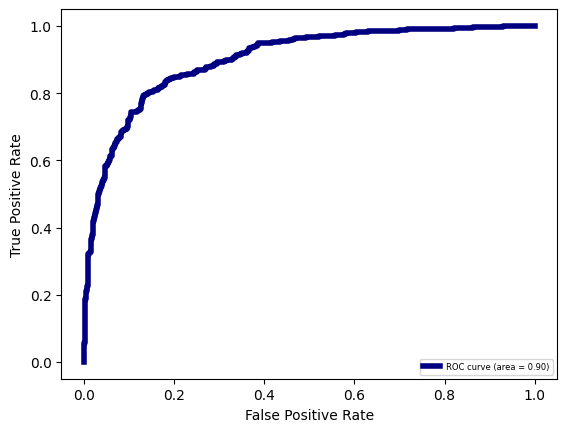

In [322]:
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_prob)
plt.plot(
    fpr,
    tpr,
    label="ROC curve (area = {0:0.2f})".format(metrics.roc_auc_score(y_test,y_prob)),
    color="navy",
#     linestyle=":",
    linewidth=4,
)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right",prop={'size': 6})
plt.show()


In [324]:
exp_path = 'exp/07'
os.makedirs(exp_path,exist_ok=True)
torch.save(model.state_dict(),os.path.join(exp_path,"best_model.pth"))

In [325]:
model = GloveModel(100,32,1,3)
ckpt = torch.load(os.path.join(exp_path,"best_model.pth"))
model.load_state_dict(ckpt)

<All keys matched successfully>

In [326]:
ckpt

OrderedDict([('embedding.weight',
              tensor([[-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
                      [-0.1077,  0.1105,  0.5981,  ..., -0.8316,  0.4529,  0.0826],
                      [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288],
                      ...,
                      [ 0.3609, -0.1692, -0.3270,  ...,  0.2714, -0.2919,  0.1611],
                      [-0.1046, -0.5047, -0.4933,  ...,  0.4253, -0.5125, -0.1705],
                      [ 0.2837, -0.6263, -0.4435,  ...,  0.4368, -0.8261, -0.1570]],
                     device='cuda:0')),
             ('rnn.weight_ih_l0',
              tensor([[ 0.2219,  0.1005,  0.2506,  ..., -0.0782, -0.2742, -0.1927],
                      [ 0.0961,  0.1083,  0.1230,  ..., -0.1068, -0.0272, -0.0152],
                      [-0.0746, -0.0253, -0.1701,  ...,  0.1163,  0.1143,  0.0714],
                      ...,
                      [-0.0247,  0.1625,  0.0260,  ...,  0.1776, -0.0916, -0.0596

In [327]:
exp_path = 'exp/07'
os.makedirs(exp_path,exist_ok=True)
torch.save(model,os.path.join(exp_path,"best_model.pt"))

In [331]:
ckpt = torch.load(os.path.join(exp_path,"best_model.pt"))
ckpt

GloveModel(
  (embedding): Embedding(400000, 100)
  (rnn): GRU(100, 32, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (linear1): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (sig): Sigmoid()
)